Back to [README](./README.md)

Back to the [previous notebook](./05-fitting-df_low.ipynb)

--------------------

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from setup import df, Col, Palette, quick_regression, Region, Sex
import setup.coefficient as coef

--------------------

# Offsets and More Insights

In the [previous notebook](./05-fitting-df_low.ipynb) we succeeded
in finding a fit fot the lowest of the charge levels over the
age of the individuals in our dataset, `df_low`.

Now we are interested in the fits for the two other levels as well.
If we look back at the way we isolated the first level of our data, we can use a similar
approach to do the same with the other two.  However, this time we are in a better position:
we know that we are dealing with three functions of the shape
$$
c_{i}(a) = A \cdot a^2 + n_{i},\quad i \in \{1, 2, 3\}
$$
where $A$ is the "slope" we got from our earlier inspections.
(Note that we call it the "slope" since we obtained it by regarding
$a^2$ as the independent variable, like as if we substituted it with
$x \equiv a^2$.)  And yes, we are assuming
it is the same for all three levels at this point.  $c_{i}(a)$ and $n_{i}$
take the same roles as in our linear assumption from earlier.

Now, instead of dividing by the age in order to 'linearize' the data points, we can subtract
the term $A \cdot a^2$ from the charges to get what
looks like data points oscillating around their three different offsets:

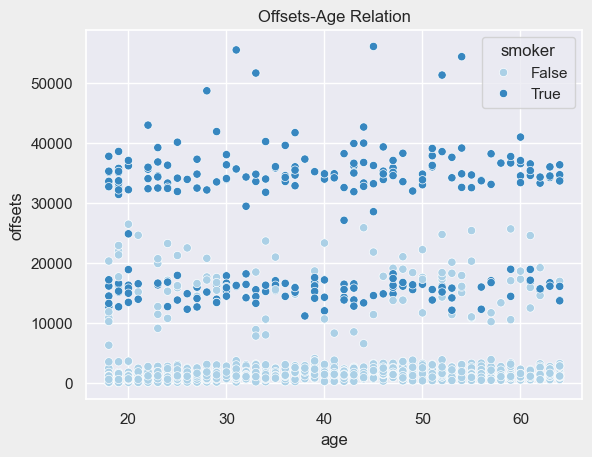

In [2]:
# Introduce the 'offsets' column into our DataFrame object
model = quick_regression(df[Col.age]**2, df[Col.charges])
df[Col.offsets] = df.charges - model.slope * df.age**2

sns.scatterplot(data=df, x=Col.age, y=Col.offsets, hue=Col.smoker, palette=Palette.bl)
plt.title('Offsets-Age Relation')
plt.show()

What essentially did here is removing the influence of the age on the charges to
allow other effects and factors to reveal themselves more clearly, as we will
soon discover.

In an attempt to separate the levels, it would be nice to see if other factors play
into their contribution.  Thus, let us quickly look at these offsets with respect to
the only quantitative column we have aside from the `age` - the `bmi` - and also put
all the qualitative columns into consideration as well.

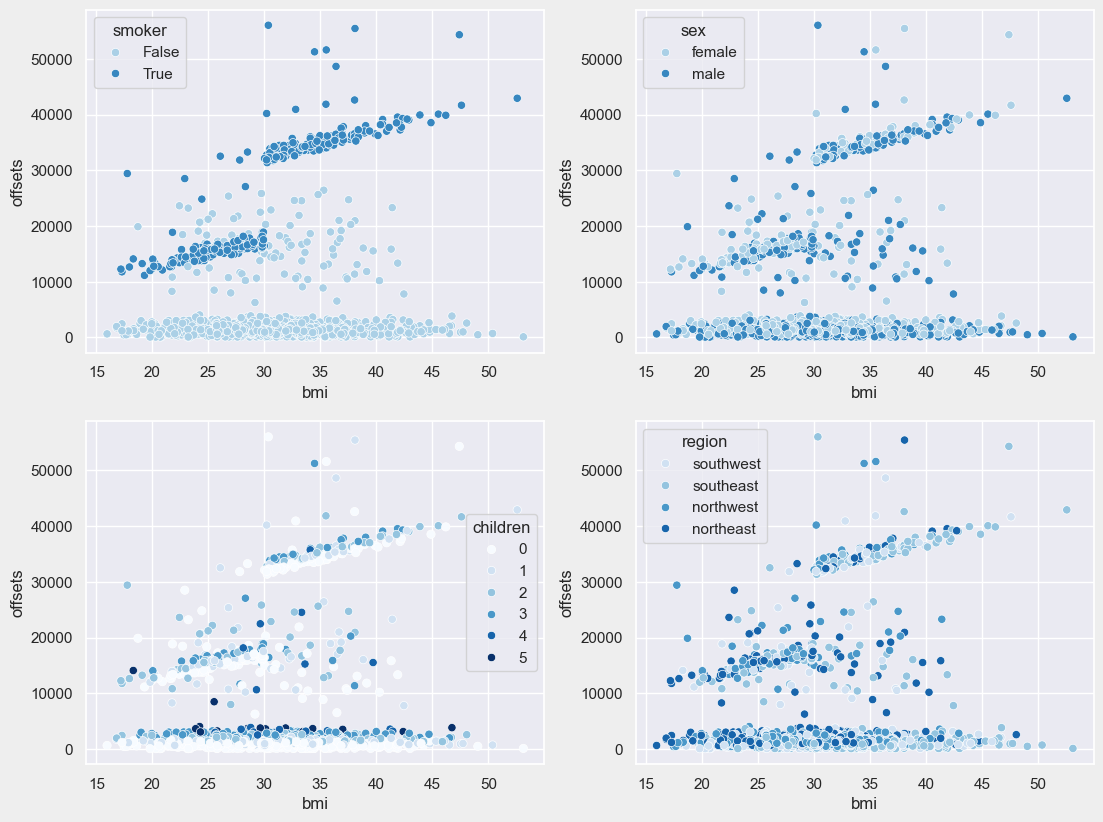

In [3]:
plt.figure(figsize=(13, 4.9*2))
plt.subplot(221)
sns.scatterplot(data=df, x=Col.bmi, y=Col.offsets, hue=Col.smoker, palette=Palette.bl)
plt.subplot(222)
sns.scatterplot(data=df, x=Col.bmi, y=Col.offsets, hue=Col.sex, palette=Palette.bl)
plt.subplot(223)
sns.scatterplot(data=df, x=Col.bmi, y=Col.offsets, hue=Col.children, palette=Palette.bl)
plt.subplot(224)
sns.scatterplot(data=df, x=Col.bmi, y=Col.offsets, hue=Col.region, palette=Palette.bl)
plt.show()

The top left graph shows that there is a clear BMI limit at which the offset jumps,
and that this goes for smokers exclusively.  On top of that, it
indicates that there is basically a linear correlation between the offset
of the smoker charges and the person's BMI.  Non-smokers do not get such a penalty,
again.

And a look at the lower left graph raises the suspicion that the number of children,
too, raises the offset. The general tendency, ignoring outliers, seems to be that each
child adds a little penalty.

To make those observations a bit more clear, let us remove the non-smokers from the plots:

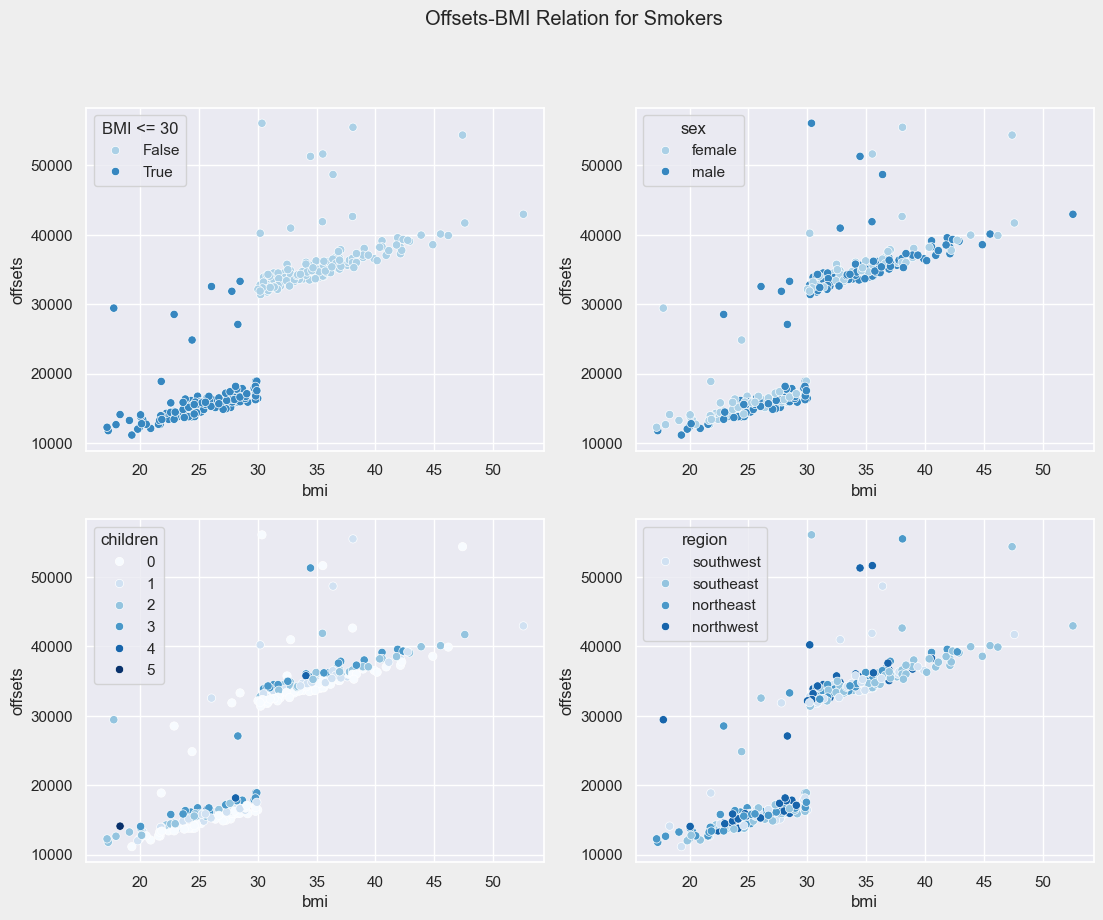

In [4]:
# Introduce the BMI category into our DataFrame object
df[Col.bmi30] = df.bmi.map(lambda bmi: bmi <= 30)   # Col.bmi30 = 'BMI <= 30'

fig = plt.figure(figsize=(13, 4.9*2))
plt.subplot(221)
sns.scatterplot(data=df[df.smoker], x=Col.bmi, y=Col.offsets, hue=Col.bmi30, palette=Palette.bl)
plt.subplot(222)
sns.scatterplot(data=df[df.smoker], x=Col.bmi, y=Col.offsets, hue=Col.sex, palette=Palette.bl)
plt.subplot(223)
sns.scatterplot(data=df[df.smoker], x=Col.bmi, y=Col.offsets, hue=Col.children, palette=Palette.bl)
plt.subplot(224)
sns.scatterplot(data=df[df.smoker], x=Col.bmi, y=Col.offsets, hue=Col.region, palette=Palette.bl)
fig.suptitle('Offsets-BMI Relation for Smokers')
plt.show()

Before we can perform a regression on those sample points, we need
to remove outliers and "fix" the jump by sticking the two areas smoothly together.

As for the outliers, it is an easy task to define that for the lower-BMI subset
an upper limit for the `offsets` value shall be given by `18700`.  This value is
arbitrarily chosen, but it separates the dense band from the outliers quite well
(see the graph below).

Coming up for a criterion for the upper-BMI data selection is an easy
exercise as well (thanks to the "clean" distribution of the data points
themselves). One could define a line that separates the outliers from
the dense band by estimating a slope just by eyesight, and
pick a random point through which this line shall go.  Using the form
$$
\mathrm{offsets}(\mathrm{bmi}) = m \cdot (\mathrm{bmi} - \mathrm{bmi}_0)
+ \mathrm{offsets}_0
$$
where $(\mathrm{bmi}_0, \mathrm{offsets}_0)$ is said point and $m$ is the estimated slope,
the condition for the points to be kept in further computations is that
their acutal `offsets` value must be lower than what this formula predicts.

For this purpose, let us choose $m \approx 500$ and $(\mathrm{bmi}_0,
\mathrm{offsets}_0) = (30, 37k)$.

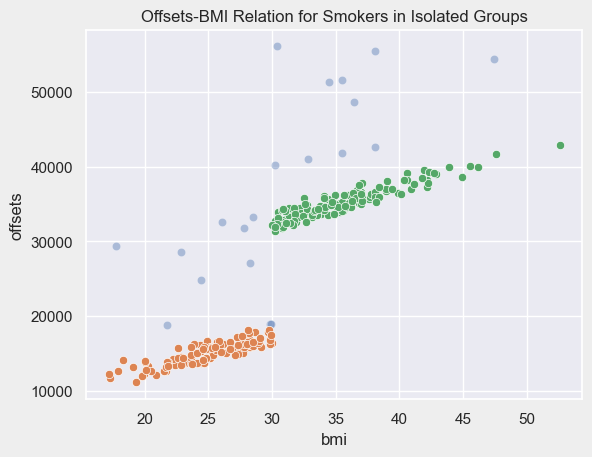

In [5]:
# Split bmi_df into smaller DataFrame objects
df_lower = df[(df[Col.smoker]) & (df[Col.bmi30])].copy()
df_upper = df[(df[Col.smoker]) & (~df[Col.bmi30])].copy()

# Apply the filter masks to remove outliers
df_lower_filtered = df_lower[df_lower[Col.offsets] < 18.7e3].copy()
df_upper_filtered = df_upper[df_upper.eval('offsets < 5e2 * (bmi - 30) + 37e3')].copy()

# Plot to verify successful extraction
sns.scatterplot(data=df[df[Col.smoker]], x=Col.bmi, y=Col.offsets, alpha=.4)
sns.scatterplot(data=df_lower_filtered, x=Col.bmi, y=Col.offsets)
sns.scatterplot(data=df_upper_filtered, x=Col.bmi, y=Col.offsets)
plt.title('Offsets-BMI Relation for Smokers in Isolated Groups')
plt.show()

The blue points are the ones that are now removed from the smaller
sub-`DataFrame` objects.  The orange and the green subsets are the ones
we are going to join in the next step to perform a unified linear regression
on them.

As for the criterion as to *how* to join them: we are going to use the fact
that the childless individuals define the bottom line of each of those
subsets.  And we will demand that the lowest `offsets` in a small range
around the `bmi` 30 shall match up.

We will store the difference of those two points in a variable `step` that
we will later use to reconstruct the jump for our regression line.

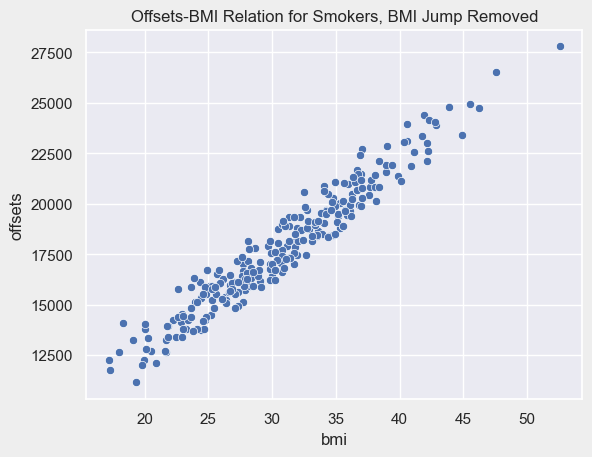

In [6]:
# Compute the step as described above;
# Let 29.5 < bmi < 30.5 be the range in which we search the matching points
step = df_upper_filtered[df_upper_filtered.bmi < 30.5].offsets.min() - \
    df_lower_filtered[df_lower_filtered.bmi > 29.5].offsets.min()

# Create a copy of the unshifted data frame and pull it down using the `step`
df_upper_filtered_shifted = df_upper_filtered.copy()
df_upper_filtered_shifted.offsets -= step

# Create a joined DataFrame
df_filtered_joined = pd.concat([df_lower_filtered, df_upper_filtered_shifted], axis=0)

# Plot it
sns.scatterplot(data=df_filtered_joined, x=Col.bmi, y=Col.offsets)
plt.title('Offsets-BMI Relation for Smokers, BMI Jump Removed')
plt.show()

It appears that the choices made so far produced a very nice dataset to
perform a linear regression on.  We are going to reuse the `statsmodels.api`
package for that since it offers us the most convenient way to get confidence
niveous for the results.

In [7]:
# Linear Regression
x  = df_filtered_joined.bmi
y  = df_filtered_joined.offsets

model = quick_regression(x, y)
model.result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                offsets   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.934
Method:                 Least Squares   F-statistic:                     3605.
Date:                Thu, 16 May 2024   Prob (F-statistic):          2.70e-151
Time:                        18:47:39   Log-Likelihood:                -2049.1
No. Observations:                 254   AIC:                             4102.
Df Residuals:                     252   BIC:                             4109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3534.4645    242.427     14.580      0.000    3057.024    4011.905
bmi          464.4636      7.736     60.038      0.000     449.228     479.699
==============================================================================
Omnibus:                       10.672   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.005   Jarque-Bera (JB):                8.989
Skew:                           0.378   Prob(JB):                       0.0112
Kurtosis:                       2.474   Cond. No.                         156.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, use the model to create the data points (predictions) for our line plot
that we want to lay over our scatter plot to illustrate both at the same time:

In [8]:
# Add the prediction data to the data frames
df_lower_filtered[Col.line] = model.predict(df_lower_filtered.bmi)
df_upper_filtered[Col.line] = model.predict(df_upper_filtered.bmi) + step

Here, we reintroduced the `step` so the line sits in the correct area of the dataset.
We aim to look at our result for the (filtered but otherwise) unmodified data frames, not the
ones that we "glued" together.

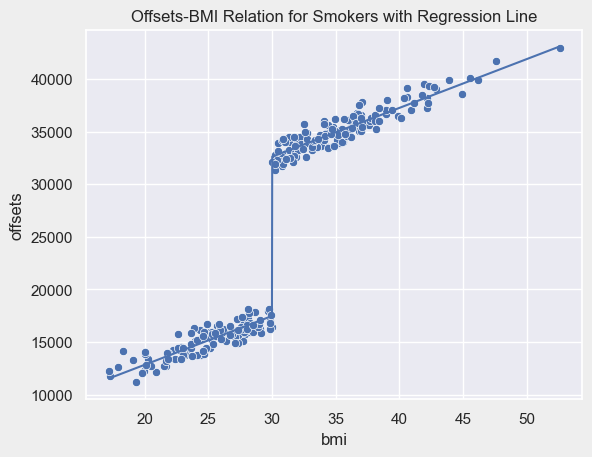

In [9]:
# Plot the data
df_filtered_fitted_joined = pd.concat([df_lower_filtered, df_upper_filtered])
sns.scatterplot(data=df_filtered_fitted_joined, x=Col.bmi, y='offsets')
sns.lineplot(data=df_filtered_fitted_joined, x=Col.bmi, y='line')
plt.title('Offsets-BMI Relation for Smokers with Regression Line')
plt.show()

At this point, we shall quit our quantitative investigation.  We discovered
a lot and, as we will see in the final notebook, more discoveries only lead
to more, new questions.  And we also went far beyond the original intent of
this very exercise already.  So, let us simply store our final data frame
in its own `.csv` file before we roll back our filters and look at our
predictions in a quick summary:

In [10]:
bmi_col = 'offsets without BMI influence'
df[bmi_col] = df.apply(lambda row: row[Col.offsets] - row[Col.bmi] * model.slope if row[Col.smoker] else row[Col.offsets], axis=1)
df.to_csv('./data/final-df.csv', encoding='UTF-8', index=False)

# Summary

In this notebook, we found and quantified an influence factor on the insurance
charges: the BMI.  Theoretically, we are now able to remove this factor from
our `charges` columns as well to allow the smaller influences to present
themselves more visibly.  (We actually did that in the last few lines of code:
we removed the dynamic BMI component, which allows us now to visualize finer
correlations to what remains.)  But instead of pursuing that in depth, we shall
only illustrate what becomes possible now in the next notebook, and instead
formulate our conclusion so far and analyze its precision with respect to the
given data.

To give a closed formula for the predicted `charges`
$c_{s, c, r}(a, \mathrm{bmi})$ in dependance of the age $a$ and the BMI $\mathrm{bmi}$
with parameters 'smoking habits' $s$, number of children $c$ and region $r$,
we found it to be of the shape
$$
c_{s, c, r}(a, \mathrm{bmi}) =
    \left\lbrace 
        \begin{array}{rl}
            \mathrm{s} = \mathrm{True}: & A a^2 +
                        B_1 (1 + \mathrm{step}\ \Theta(\mathrm{bmi} - 30))\ \mathrm{bmi} +
                        C_{c, r}\\
            \mathrm{else}: & A a^2 + B_0 + C_{c, r}\\
        \end{array}
    \right.,
    \qquad
    \Theta(x) \equiv
        \left\lbrace
            \begin{array}{rl}
                x \leq 0:       & 0\\
                \mathrm{else}:  & 1\\
            \end{array}
        \right..
$$
And we identified the coefficients $A$, $B_0$, $B_1$ and $\mathrm{step}$ so far:

| coefficient     | value              | where obtained                                                                                            |
| --------------- | ------------------ | --------------------------------------------------------------------------------------------------------- |
| $A$             | 3.3639813030572436 | [06-linear-regression-using-scikit-learn.ipynb](./06-linear-regression-using-scikit-learn.ipynb); `slope` |
| $B_0$           | 1160.1072156361256 | [06-linear-regression-using-scikit-learn.ipynb](./06-linear-regression-using-scikit-learn); `intercept`   |
| $B_1$           | 464.46357000589967 | [09-offsets-and-more-insights.ipynb](./09-offsets-and-more-insights.ipynb); `slope`                       |
| $\mathrm{step}$ | 15139.234063287839 | [09-offsets-and-more-insights.ipynb](./09-offsets-and-more-insights.ipynb); `step`                        |

In [11]:
# Read the values from the `setup` package
print(f'A    = {coef.A} +/- {coef.A - coef.A_lower}')
print(f'B0   = {coef.B0} +/- {coef.B0 - coef.B0_lower}')
print(f'B1   = {coef.B1} +/- {coef.B1 - coef.B1_lower}')
print(f'step = {coef.STEP}')

A    = 3.3639813030572436 +/- 0.04314784294607499
B0   = 1160.1072156361256 +/- 88.70507357108272
B1   = 464.46357000589967 +/- 15.749340468142009
step = 15139.234063287839


(Confidence margins are given for 95% certainty.)

What we have not quantified so far is the effect of the region
and the number of children, encoded in the term $C_{c, r}$.

The illustrations in the [next notebook](./10-outlook.ipynb)
will, however, reveal that they can be obtained as well (in
a similar fashion as we identified the other parameters).
However, we shall not attempt to find them in this repository.

--------------------

Back to the [README](./README.md)

To the [next notebook](./10-outlook.ipynb)